# Réalisez une analyse de sentiments grâce au Deep Learning

## Data preprocessing

In [64]:
import pandas as pd
import re

# Chargement du fichier avec un encodage différent
df = pd.read_csv("../data/input/training.1600000.processed.noemoticon.utf-8.csv", 
                 header=None, 
                 names=["id", "timestamp", "date", "query", "user", "tweet"], 
                 )

# Vérification des premières lignes
df.head()

,id,timestamp,date,query,user,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [65]:
nan_rows = df[df.isna().any(axis=1)]
nan_rows

,id,timestamp,date,query,user,tweet


### Clean

In [66]:
# Supprimer les tweets vides (NaN ou chaînes vides)
df = df[~(df['tweet'].isna() | (df['tweet'] == ""))]

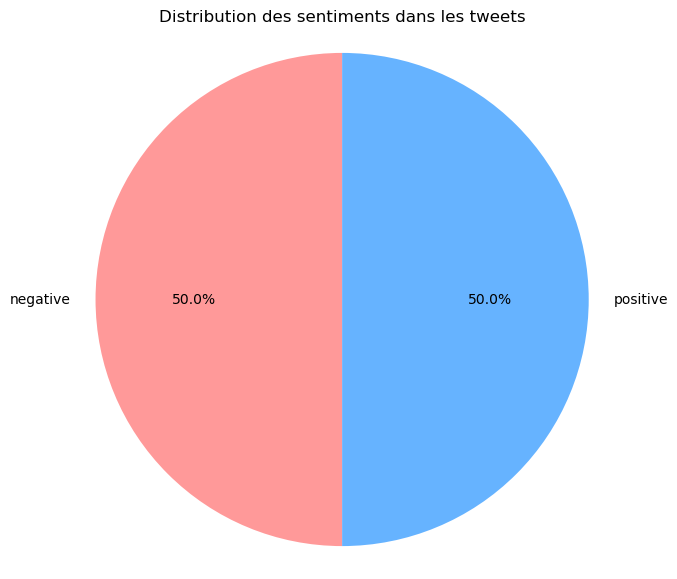

In [67]:
import matplotlib.pyplot as plt

# Distribution des labels dans la colonne 'id'
label_counts = df['id'].value_counts()

# Map des ids vers les labels
label_map = {0: 'negative', 4: 'positive', 2: 'neutral'}

# Remap des ids vers les labels
label_counts.index = label_counts.index.map(label_map)

# Création du graphique camembert
plt.figure(figsize=(7, 7))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff','#99ff99'])
plt.title("Distribution des sentiments dans les tweets")
plt.axis('equal')  # Pour un cercle parfait
plt.show()


   id   timestamp                          date     query             user  \
0   0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY  _TheSpecialOne_   
1   0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY    scotthamilton   
2   0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY         mattycus   
3   0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY          ElleCTF   
4   0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY           Karoli   

                                               tweet  
0  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1  is upset that he can't update his Facebook by ...  
2  @Kenichan I dived many times for the ball. Man...  
3    my whole body feels itchy and like its on fire   
4  @nationwideclass no, it's not behaving at all....  


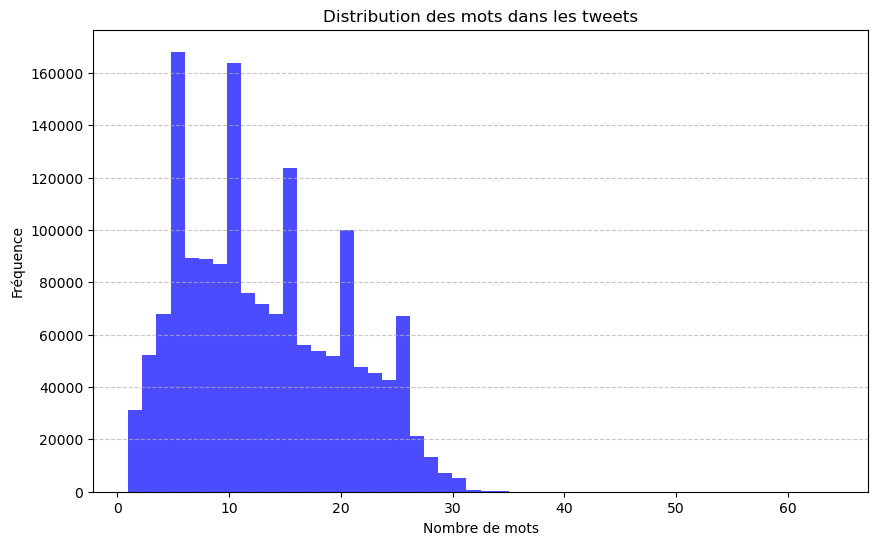

Longueur maximale d'un tweet (en mots) : 64


In [68]:
import pandas as pd
import matplotlib.pyplot as plt

# Chargement du fichier avec un encodage spécifique
df = pd.read_csv("../data/input/training.1600000.processed.noemoticon.utf-8.csv", 
                 header=None, 
                 names=["id", "timestamp", "date", "query", "user", "tweet"])

# Vérification des premières lignes
print(df.head())

# Calcul de la longueur des tweets (en nombre de mots)
df['word_count'] = df['tweet'].apply(lambda x: len(str(x).split()))

# Distribution des longueurs des tweets
plt.figure(figsize=(10, 6))
plt.hist(df['word_count'], bins=50, color='blue', alpha=0.7)
plt.title("Distribution des mots dans les tweets")
plt.xlabel("Nombre de mots")
plt.ylabel("Fréquence")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Calcul de la longueur maximale
max_length = df['word_count'].max()
print(f"Longueur maximale d'un tweet (en mots) : {max_length}")

### Tokensisation

[nltk_data] Downloading package stopwords to /home/bruno/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/bruno/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


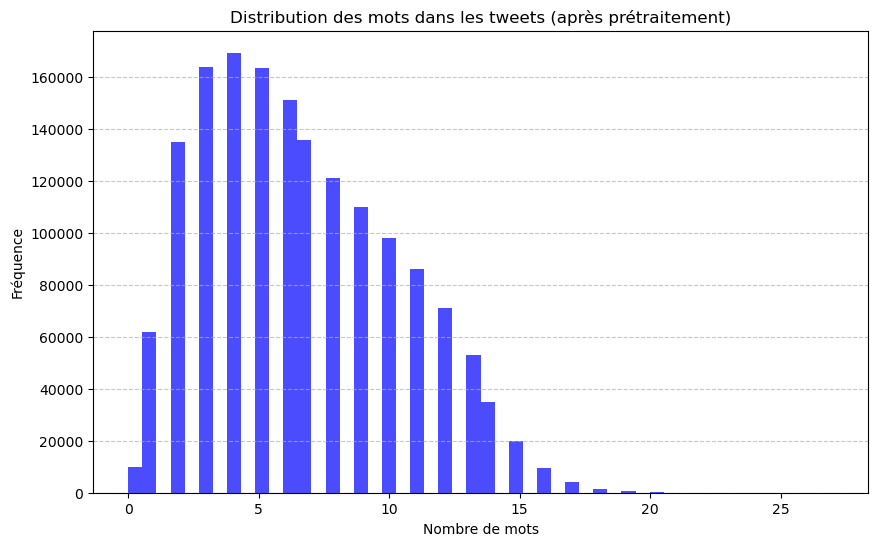

Longueur maximale d'un tweet (après prétraitement, en mots) : 27


In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import emoji

# Télécharger les ressources nécessaires de NLTK
nltk.download('stopwords')
nltk.download('wordnet')

# Initialisation de stopwords et lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_tweet(tweet, min_word_length=3, vocabulary=None):
    """
    Prétraitement d'un tweet individuel :
    - Mise en minuscule
    - Suppression des URLs, mentions, hashtags, ponctuation et espaces inutiles
    - Suppression des stopwords
    - Suppression des artefacts spécifiques aux tweets (chiffres, emojis, répétitions)
    - Lemmatisation des mots
    - Filtrage par longueur de mot
    - Option : Limitation du vocabulaire à une liste donnée
    
    Args:
    tweet (str): Le texte brut du tweet.
    min_word_length (int): Longueur minimale pour conserver un mot.
    vocabulary (set): Ensemble optionnel de mots autorisés dans le vocabulaire final.
    
    Returns:
    str: Tweet prétraité.
    """
    # Mise en minuscule
    tweet = tweet.lower()

    # Suppression des URLs, mentions et hashtags
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet)  # URLs
    tweet = re.sub(r'@\w+', '', tweet)  # Mentions
    tweet = re.sub(r'#\w+', '', tweet)  # Hashtags

    # Suppression de la ponctuation et des espaces multiples
    tweet = re.sub(r'[^\w\s]', '', tweet)  # Ponctuation
    tweet = re.sub(r'\s+', ' ', tweet).strip()  # Espaces multiples et espaces en début/fin

    # Suppression des artefacts spécifiques aux tweets
    tweet = re.sub(r'\d+', '', tweet)  # Suppression des chiffres
    tweet = emoji.replace_emoji(tweet, replace="")  # Suppression des emojis
    tweet = re.sub(r'(.)\1{2,}', r'\1', tweet)  # Réduction des répétitions de caractères

    # Tokenisation, suppression des stopwords et lemmatisation
    words = [
        lemmatizer.lemmatize(word)
        for word in tweet.split()
        if word not in stop_words and len(word) >= min_word_length
    ]

    # Option : Limiter au vocabulaire donné
    if vocabulary is not None:
        words = [word for word in words if word in vocabulary]

    # Reconstruction du tweet
    return " ".join(words)

# Chargement des données
df = pd.read_csv("../data/input/training.1600000.processed.noemoticon.utf-8.csv", 
                 header=None, 
                 names=["id", "timestamp", "date", "query", "user", "tweet"])

# Application du prétraitement
df['cleaned_tweet'] = df['tweet'].apply(preprocess_tweet)

# Calcul de la longueur des tweets (en nombre de mots) après prétraitement
df['word_count'] = df['cleaned_tweet'].apply(lambda x: len(x.split()))

# Distribution des longueurs des tweets
plt.figure(figsize=(10, 6))
plt.hist(df['word_count'], bins=50, color='blue', alpha=0.7)
plt.title("Distribution des mots dans les tweets (après prétraitement)")
plt.xlabel("Nombre de mots")
plt.ylabel("Fréquence")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Calcul de la longueur maximale
max_length = df['word_count'].max()
print(f"Longueur maximale d'un tweet (après prétraitement, en mots) : {max_length}")


In [70]:
max_length_adjusted = int(df['word_count'].quantile(0.95))
print(f"Longueur ajustée pour couvrir 95% des tweets : {max_length_adjusted}")

Longueur ajustée pour couvrir 95% des tweets : 13


In [71]:
from collections import Counter
all_words = " ".join(df['cleaned_tweet']).split()
vocab = Counter(all_words)
print(f"Taille du vocabulaire unique : {len(vocab)}")

Taille du vocabulaire unique : 380425


In [72]:
from collections import Counter

# Obtenez tous les mots uniques
all_words = " ".join(df['cleaned_tweet']).split()
word_counts = Counter(all_words)

# Affichez les mots les plus fréquents et les plus rares
print("10 mots les plus fréquents :")
print(word_counts.most_common(10))

print("\n10 mots les plus rares :")
print([word for word, count in word_counts.items() if count == 1][:10])

10 mots les plus fréquents :


[('day', 104952), ('good', 89544), ('get', 85940), ('like', 79134), ('love', 68273), ('dont', 66960), ('work', 66678), ('today', 66380), ('going', 64136), ('time', 63967)]

10 mots les plus rares :
['muera', 'doucheclown', 'misslilly', 'twanking', 'uids', 'manwas', 'samro', 'coitus', 'nikster', 'shortsand']


In [73]:
#import pandas as pd

# Exemple de DataFrame
#data = {'tweet': ["@user Check out this amazing link: https://example.com! #amazing #fun"]}
#df = pd.DataFrame(data)

# Application de la fonction
#df['cleaned_tweet'] = df['tweet'].apply(preprocess_tweet)

#print(df)

In [74]:
from collections import Counter

all_words = " ".join(df['cleaned_tweet']).split()
word_counts = Counter(all_words)

# Analyser les mots les plus rares
rare_words = [word for word, count in word_counts.items() if count == 1]
print(f"Nombre de mots rares (fréquence = 1) : {len(rare_words)}")
print("Exemples de mots rares :", rare_words[:10])

# Analyser les mots les plus longs
long_words = [word for word in all_words if len(word) > 20]
print(f"Nombre de mots très longs (len > 20) : {len(long_words)}")
print("Exemples de mots longs :", long_words[:10])

Nombre de mots rares (fréquence = 1) : 264798
Exemples de mots rares : ['muera', 'doucheclown', 'misslilly', 'twanking', 'uids', 'manwas', 'samro', 'coitus', 'nikster', 'shortsand']
Nombre de mots très longs (len > 20) : 3111
Exemples de mots longs : ['packingpaintingcleaning', 'infrastructureinstead', 'superpupermegaovermodel', 'imagestoo_big_for_flickr', 'schoolworkouthomehomework', 'reproachfulyourebreakingmyheart', 'twittercomscroobiuspip', 'penderhakacongratulationbut', 'greaterlansingwelcome', 'traininghumanitiesastronomy']


In [78]:
import numpy as np
from gensim.models import KeyedVectors

# Charger GloVe Twitter
glove_file = "../data/input/glove.twitter.27B.200d.txt"  # Ajustez le chemin si nécessaire
glove_model = KeyedVectors.load_word2vec_format(glove_file, binary=False, no_header=True)

def clean_with_glove(tweet, glove_model, threshold=0.6, max_word_length=20):
    """
    Nettoyer un tweet en utilisant GloVe Twitter :
    - Supprime les mots non valides (non présents dans GloVe).
    - Corrige les fautes d'orthographe en utilisant la similarité sémantique.
    - Gère les mots collés en essayant de les segmenter.

    Args:
    tweet (str): Texte brut du tweet.
    glove_model (KeyedVectors): Modèle GloVe chargé.
    threshold (float): Seuil pour considérer un mot comme valide sémantiquement.
    max_word_length (int): Longueur maximale pour conserver un mot.

    Returns:
    str: Tweet nettoyé.
    """
    def is_valid_word(word):
        """Vérifie si un mot est dans GloVe ou corrige les mots proches."""
        if len(word) > max_word_length:
            return None  # Supprime les mots trop longs
        if word in glove_model:
            return word  # Mot valide
        # Sinon, trouver un mot proche
        try:
            similar_words = glove_model.most_similar(word, topn=1) if word else []
        except KeyError:
            similar_words = []
        if similar_words and similar_words[0][1] > threshold:
            return similar_words[0][0]  # Retourne le mot corrigé
        return None  # Mot invalide

    def segment_words(word):
        """Essaye de segmenter les mots collés en utilisant GloVe."""
        for i in range(1, len(word)):
            left, right = word[:i], word[i:]
            if left in glove_model and right in glove_model:
                return left + " " + right  # Retourne les mots segmentés
        return None  # Retourne None si aucune segmentation valide

    # Tokenisation
    words = tweet.split()
    
    # Nettoyage des mots
    cleaned_words = []
    for word in words:
        valid_word = is_valid_word(word)
        if valid_word:
            cleaned_words.append(valid_word)
        else:
            # Essayer de segmenter les mots collés
            segmented_word = segment_words(word)
            if segmented_word:
                cleaned_words.extend(segmented_word.split())  # Ajouter les mots segmentés
            # Sinon, ignorer le mot

    return " ".join(cleaned_words)



In [87]:
# Charger GloVe Twitter
from gensim.models import KeyedVectors

glove_file = "../data/input/glove.twitter.27B.200d.txt"  # Chemin vers le fichier GloVe
glove_model = KeyedVectors.load_word2vec_format(glove_file, binary=False, no_header=True)

# Exemple d'application
df['cleaned_glove_tweet'] = df['cleaned_tweet'].apply(
    lambda tweet: clean_with_glove(tweet, glove_model)
)

min_freq = 5
word_counts = Counter(" ".join(df['cleaned_glove_tweet']).split())
frequent_words = {word for word, count in word_counts.items() if count >= min_freq}

# Filtrer les tweets en gardant uniquement les mots fréquents
df['filtered_tweet'] = df['cleaned_glove_tweet'].apply(
    lambda tweet: " ".join([word for word in tweet.split() if word in frequent_words])
)

In [86]:
from collections import Counter

# Obtenir tous les mots uniques après nettoyage
all_words = " ".join(df['filtered_tweet']).split()
word_counts = Counter(all_words)

# Afficher les mots fréquents
print("10 mots les plus fréquents :")
print(word_counts.most_common(10))

# Afficher les mots rares
print("\n10 mots les plus rares :")
print([word for word, count in word_counts.items() if count == 1][:10])

from collections import Counter
all_words = " ".join(df['filtered_tweet']).split()
vocab = Counter(all_words)
print(f"Taille du vocabulaire unique filtered_tweet : {len(vocab)}")

all_words = " ".join(df['tweet']).split()
vocab = Counter(all_words)
print(f"Taille du vocabulaire unique sur tweet: {len(vocab)}")

KeyError: 'filtered_tweet'